# Imports

In [46]:
import numpy as np
import os
import random

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import DataLoader, Dataset

import time
from tqdm import tqdm

print('Imports complete')

Imports complete


# Configurations

In [2]:
# Model Parameters
num_epochs = 2
batch_size = 32
learning_rate = 0.002
num_workers = 32 #print(os.cpu_count())
num_classes = 2

#Paths
base_path = '/project/GutIntelligenceLab/eqp6pg/test/'
train_path = base_path + 'train/'
val_path = base_path + 'val/'
test_path = base_path + 'test/'

#classes
classes = ('inova', 'uva')

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
print('Train INOVA:', len(os.listdir(train_path+'inova/')),
      'Train UVA:', len(os.listdir(train_path+'uva/')))
print('Valid INOVA:', len(os.listdir(val_path+'inova/')),
      'Valid UVA:', len(os.listdir(val_path+'uva/')))
print('Test INOVA:', len(os.listdir(test_path+'inova/')),
      'Test UVA:', len(os.listdir(test_path+'uva/')))

Train INOVA: 600 Train UVA: 600
Valid INOVA: 150 Valid UVA: 150
Test INOVA: 150 Test UVA: 150


In [4]:
inova_images = random.sample(os.listdir(train_path+'inova/'), 50)
uva_images = random.sample(os.listdir(train_path+'uva/'), 50)

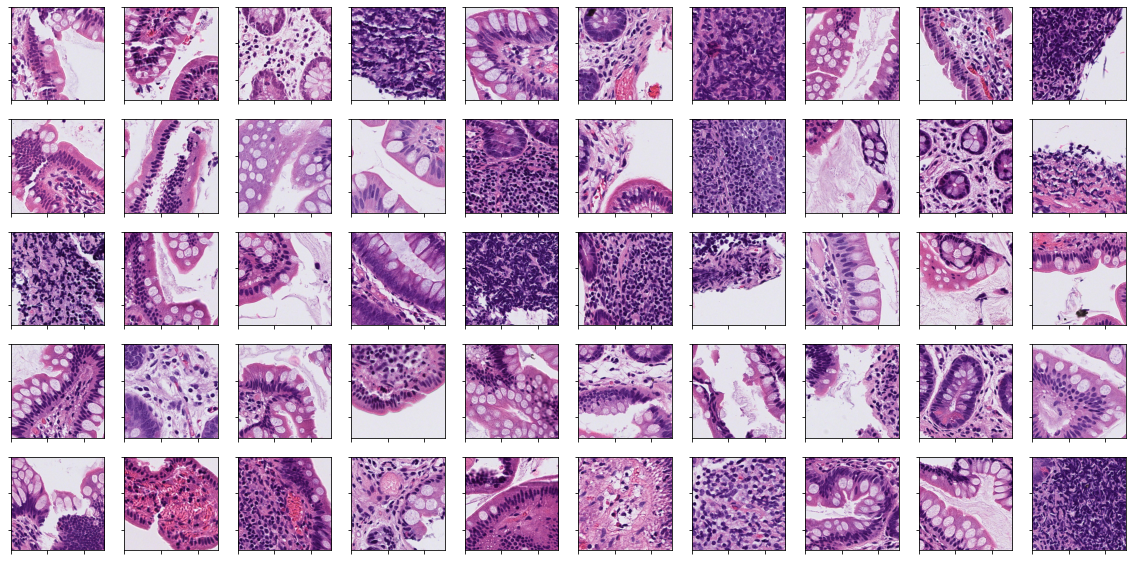

In [6]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = inova_images[m + n*10]
        image = Image.open(train_path + 'inova/' + img_id)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

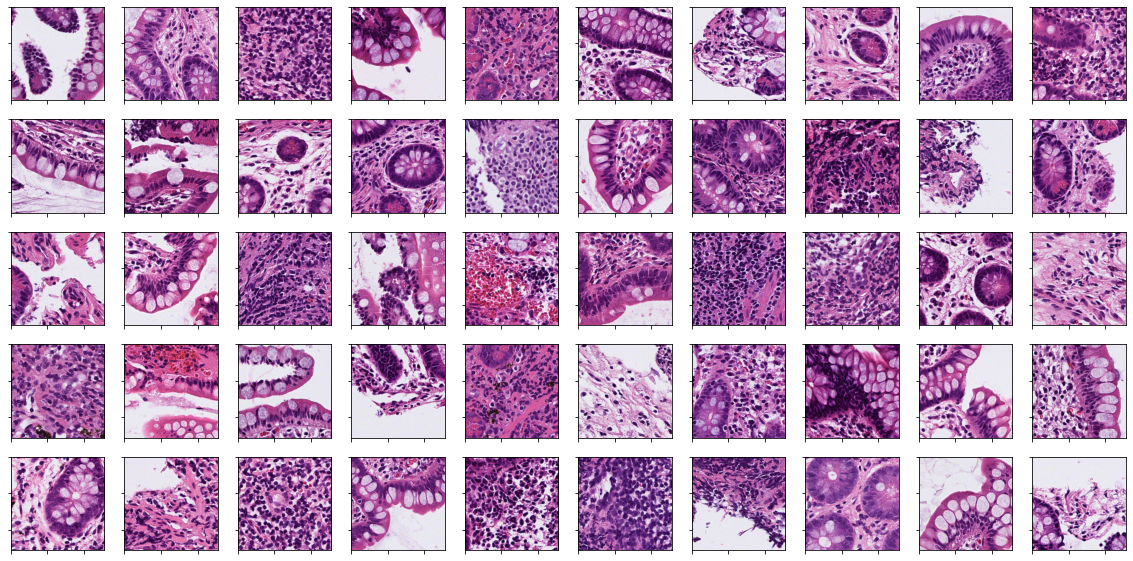

In [7]:
fig, ax = plt.subplots(5, 10, figsize=(20,10))

for n in range(5):
    for m in range(10):
        img_id = uva_images[m + n*10]
        image = Image.open(train_path + 'uva/' + img_id)
        ax[n,m].imshow(image)
        ax[n,m].grid(False)
        ax[n,m].tick_params(labelbottom=False, labelleft=False)

In [8]:
#transformations

transform_train = transforms.Compose([transforms.ToTensor(),
                                      transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_val = transforms.Compose([transforms.ToTensor(),
                                    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToTensor(),
                                     transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])])

In [9]:
#datasets

train_data = datasets.ImageFolder(train_path,transform=transform_train)
val_data = datasets.ImageFolder(val_path,transform=transform_val)
test_data = datasets.ImageFolder(test_path,transform=transform_test)

In [36]:
#dataloaders

train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [11]:
print(len(train_dataloader), len(val_dataloader), len(test_dataloader))

37 9 10


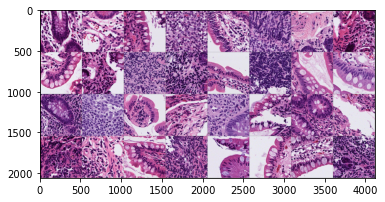

uva uva inova uva inova uva inova uva uva uva inova inova inova inova uva inova inova inova inova uva inova inova uva uva uva uva inova uva uva uva uva inova


In [12]:
def imshow(img):
  ''' function to show image '''
  img = img / 2 + 0.5 # unnormalize
  npimg = img.numpy() # convert to numpy objects
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

# get random training images with iter function
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# call function on our images
imshow(torchvision.utils.make_grid(images))

# print the class of the image
print(' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [13]:
#Using pretrained resnet18

model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

#add a new final layer
nr_filters = model.fc.in_features  #number of input features of last layer
model.fc = nn.Linear(nr_filters, num_classes)

model = model.to(device)
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=learning_rate)

In [21]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_acc = 0.0
min_loss = np.Inf

since = time.time()

for e in range(num_epochs):
    
    train_loss = 0.0
    train_correct = 0
    train_total = 0
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Train the model
    model.train()
    for i, data in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        images , labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Loss and accuracy
        train_loss += loss.item()
        _, predictions = torch.max(outputs.data, 1)
        train_correct += (predictions == labels).sum().item()
        train_total += labels.size(0)
        
    
    # Evaluate the model
    model.eval()
    for i, data in tqdm(enumerate(val_dataloader), total=len(val_dataloader)):
        images , labels = data
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Loss and accuracy
        val_loss += loss.item()
        _, predictions = torch.max(outputs.data, 1)
        val_correct += (predictions == labels).sum().item()
        val_total += labels.size(0)
    
    # Average losses and accuracies
    train_loss = train_loss/len(train_dataloader)
    val_loss = val_loss/len(val_dataloader)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_acc = 100 * train_correct / train_total
    train_accuracies.append(train_acc)
    val_acc = 100 * val_correct / val_total
    val_accuracies.append(val_acc)
    
    # Updating best validation accuracy
    if best_acc < val_acc:
        best_acc = val_acc
        
    # Saving best model
    if min_loss >= val_loss:
        torch.save(model.state_dict(), 'best_model.pt')
        min_loss = val_loss
    
    print('EPOCH {}/{}'.format(e+1, num_epochs))
    print('-' * 10)

    print("Train loss: {:.6f}, Train Accuracy: {:.4f}".format(train_loss, train_acc))
    print("Validation loss: {:.6f}, Validation Accuracy: {:.4f}\n".format(val_loss, val_acc))
time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
print('Best validation accuracy: {:4f}'.format(best_acc))

100%|██████████| 9/9 [00:03<00:00,  2.46it/s]


EPOCH 1/2
----------
Train loss: 0.019995, Train Accuracy: 99.3243
Validation loss: 1.659914, Validation Accuracy: 75.0000



100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

EPOCH 2/2
----------
Train loss: 0.018329, Train Accuracy: 99.4088
Validation loss: 2.210848, Validation Accuracy: 69.7917

Training completed in 0m 44s
Best validation accuracy: 75.000000


In [22]:
# reload
model.load_state_dict(torch.load('best_model.pt'))

<All keys matched successfully>

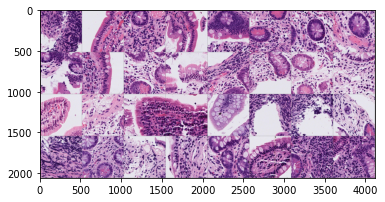

GroundTruth:  inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova


In [37]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%s' % classes[labels[j]] for j in range(batch_size)))

In [38]:
images = images.to(device)
labels = labels.to(device)
outputs = model(images)

_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:  inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova inova


In [69]:
correct = 0
total = 0
label = []
prediction = []

with torch.no_grad():
    for i, data in tqdm(enumerate(test_dataloader), total=len(test_dataloader)):
        images, labels = data
        images = images.to(device)
        outputs = model(images)
        _, predictions = torch.max(outputs.cpu().data, 1)
        total += labels.size(0)
        correct += (predictions == labels).sum().item()
        label += labels.tolist()
        prediction += predictions.tolist()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

100%|██████████| 10/10 [00:03<00:00,  2.60it/s]

Accuracy of the network on the test images: 73 %


In [70]:
print("Confusion Matrix : ")
confusion_matrix(prediction,label)

Confusion Matrix : 


array([[137,  66],
       [ 13,  84]])